# 6.4.2 XGBoost 모델

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book2/Ch6/2017DC1-all.csv') 
                              # 연속변수 타겟 VALP를 가지고 스케일 조정이 되지 않은 데이터셋인 house-unscaled-VALP.csv 불러오기
df.shape

(20495, 31)

In [ ]:
df.head(3)

,ACCESS,ACR,AGEP,BATH,BDSP,BLD,COW,ELEP,FESRP,FKITP,...,R18,R65,RAC1P,RMSP,RWAT,SCH,SCHL,SEX,VALP,VALP_B1
0,1.0,1.0,74,1.0,3.0,2.0,0,140.0,0,0.0,...,0.0,1.0,1,5.0,1.0,1,21,2,200000.0,1.0
1,1.0,3.0,46,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,1,6.0,1.0,1,16,2,850000.0,1.0
2,1.0,3.0,45,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,1,6.0,1.0,1,16,1,850000.0,1.0


In [ ]:
df.drop(['VALP_B1'], axis=1, inplace=True)   # 이진값 타겟변수 VALP_B1를 제외
df.shape

(20495, 30)

In [ ]:
# 참조 코딩
df.head(3)

,ACCESS,ACR,AGEP,BATH,BDSP,BLD,COW,ELEP,FESRP,FKITP,...,NRC,R18,R65,RAC1P,RMSP,RWAT,SCH,SCHL,SEX,VALP
0,1.0,1.0,74,1.0,3.0,2.0,0,140.0,0,0.0,...,0.0,0.0,1.0,1,5.0,1.0,1,21,2,200000.0
1,1.0,3.0,46,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,0.0,1,6.0,1.0,1,16,2,850000.0
2,1.0,3.0,45,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,0.0,1,6.0,1.0,1,16,1,850000.0


In [ ]:
data = df.drop(['VALP'], axis=1)   # 타겟변수(VALP임에 주의)를 제외한 입력변수를 data에 저장
target = df['VALP']                # 타겟변수만 target에 저장

# 50:50 데이터 변환
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의 

In [ ]:
# 기본 XGBRegressor 모델
from sklearn.metrics import r2_score

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))


[20:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r2: 0.37772


In [ ]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

parameters = {'colsample_bytree': [0.7],
              'learning_rate': [0.05],
              'max_depth': [16],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.8, 0.9]
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[20:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [16], 'min_child_weight': [4],
                         'n_estimators': [1000], 'subsample': [0.8, 0.9]},
             scoring='r2', verbose=True)

In [ ]:
print('GridSearchCV 최적 파라미터:', xgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 16, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.9}


In [ ]:
model = xgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.65886


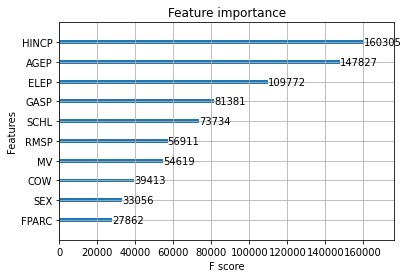

In [ ]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10);

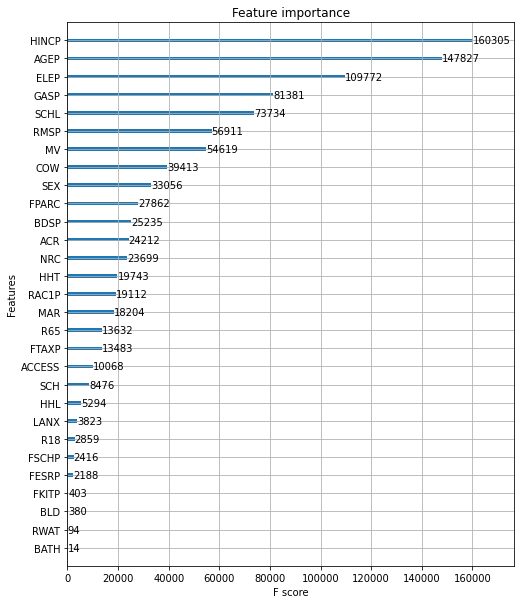

In [ ]:
# 참조 코딩
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(model, ax=ax);

# 6.4.3 LightGBM 모델

In [ ]:
# 기본 lGBMRegressor 모델
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

lgb = LGBMRegressor(random_state=0)
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.46083


In [ ]:
#그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()

parameters = {'colsample_bytree': [0.7, 0.8],
              'learning_rate': [0.1, 0.15, 0.2],
              'max_depth': [11],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.3, 0.4]
              }

lgb_grid = GridSearchCV(lgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
lgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.15, 0.2], 'max_depth': [11],
                         'min_child_weight': [4], 'n_estimators': [1000],
                         'subsample': [0.3, 0.4]},
             scoring='r2', verbose=True)

In [ ]:
print('GridSearchCV 최적 파라미터:', lgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.3}


In [ ]:
from sklearn.metrics import r2_score

model = lgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.55582


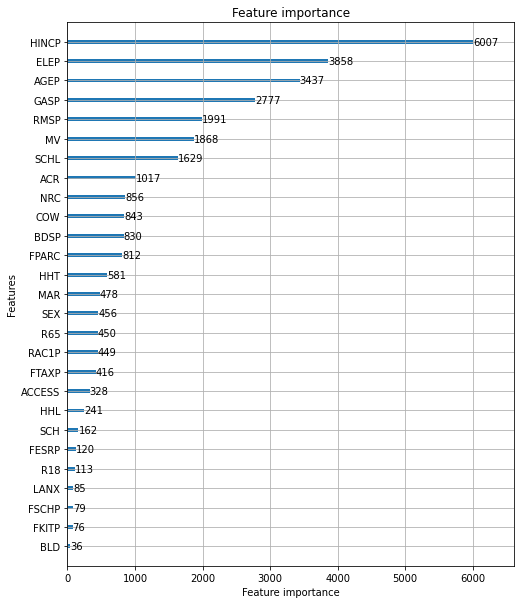

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(model, ax=ax);

# 6.5 스태킹 모델(앙상블)

In [ ]:
model_xgb = xgb_grid.best_estimator_
pred_xgb = model_xgb.predict(X_test)

model_lgb = lgb_grid.best_estimator_
pred_lgb = model_lgb.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

pred = 0.5*pred_xgb + 0.5*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.62602


In [ ]:
# 참조 코딩
pred = 0.6*pred_xgb + 0.4*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.63558


In [ ]:
# 참조 코딩
pred = 0.7*pred_xgb + 0.3*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.64364


In [ ]:
# 참조 코딩
pred = 0.8*pred_xgb + 0.2*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.65021


In [ ]:
pred = 0.9*pred_xgb + 0.1*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.65528
